In [1]:
import os
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import matplotlib.patheffects as PathEffects
import pickle
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OrdinalEncoder, StandardScaler
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
features_datastore_rest = pd.read_csv('/content/drive/MyDrive/EEG_preprocessing_datastore/Features_REST_state.csv')
features_datastore_rest['patient_identifier']= [i[:8] for i in features_datastore_rest['patient_identifier']]
features_datastore_rest['patient_identifier'] = features_datastore_rest['patient_identifier'].astype(int)
print("# of Patients:"+str(features_datastore_rest.shape[0]))
print("# of Electrode:16")
print("\n***Rest of the Features***")
print("# of Other Features:"+str(714-len([i for i in features_datastore_rest.columns if 'nl' in i or 'lf' in i])))
features_datastore_rest.head()

# of Patients:53
# of Electrode:16

***Rest of the Features***
# of Other Features:538


,lf_alpha_resting_E36,lf_beta_resting_E36,lf_delta_resting_E36,lf_theta_resting_E36,lf_mean_resting_E36,lf_max_resting_E36,lf_min_resting_E36,lf_median_resting_E36,nl_svden_resting_E36,nl_spec_enresting_E36,...,lf_delta_resting_E96,lf_theta_resting_E96,lf_mean_resting_E96,lf_max_resting_E96,lf_min_resting_E96,lf_median_resting_E96,nl_svden_resting_E96,nl_spec_enresting_E96,nl_permenresting_E96,patient_identifier
0,4884.613979,2278.624552,17200.055374,6866.060694,89740.273531,9.384269e+08,63.744193,2163.662325,0.522139,0.622730,...,10967.780996,6948.776700,41233.978648,3.930679e+08,5.355479,2948.788517,0.521534,0.553742,0.727733,2010002
1,4449.706266,2262.541526,19716.190512,7544.042248,76589.372973,7.777201e+08,96.528437,2274.685941,0.521945,0.566196,...,41740.250813,15827.252140,98990.529205,8.957127e+08,123.507787,4814.944812,0.573827,0.646714,0.780744,2010004
2,2535.166056,2705.244726,5962.754681,2638.860812,21714.444838,2.003181e+08,5.312277,2711.105520,0.670677,0.683835,...,11533.986552,4876.374359,13497.246134,6.684807e+07,69.096552,3490.536240,0.568535,0.614972,0.806063,2010005
3,4719.376369,2299.826126,16074.572713,6303.707905,48324.405457,4.815979e+08,21.432547,2347.665332,0.572527,0.640041,...,18683.117672,7575.423961,64030.047305,6.423434e+08,12.892636,3463.923658,0.532926,0.496539,0.684586,2010006
4,7827.445436,3818.779974,33842.519264,12699.762977,71679.363955,6.715888e+08,788.428172,3719.177604,0.385161,0.449255,...,79698.436736,29945.553683,111923.551768,8.038292e+08,414.748991,8716.870511,0.293716,0.339961,0.692474,2010008


In [4]:
df = pd.read_csv('/content/drive/MyDrive/EEG_preprocessing_datastore/demographic_data.csv')
df.head()

,no.,sex,age,eeg.date,education,IQ,main.disorder,specific.disorder,AB.A.delta.a.FP1,AB.A.delta.b.FP2,...,COH.F.gamma.o.Pz.p.P4,COH.F.gamma.o.Pz.q.T6,COH.F.gamma.o.Pz.r.O1,COH.F.gamma.o.Pz.s.O2,COH.F.gamma.p.P4.q.T6,COH.F.gamma.p.P4.r.O1,COH.F.gamma.p.P4.s.O2,COH.F.gamma.q.T6.r.O1,COH.F.gamma.q.T6.s.O2,COH.F.gamma.r.O1.s.O2
0,1,M,57.0,2012.8.30,NaN,NaN,Addictive disorder,Alcohol use disorder,35.998557,21.717375,...,55.989192,16.739679,23.452271,45.678820,30.167520,16.918761,48.850427,9.422630,34.507082,28.613029
1,2,M,37.0,2012.9.6,6.0,120.0,Addictive disorder,Alcohol use disorder,13.425118,11.002916,...,45.595619,17.510824,26.777368,28.201062,57.108861,32.375401,60.351749,13.900981,57.831848,43.463261
2,3,M,32.0,2012.9.10,16.0,113.0,Addictive disorder,Alcohol use disorder,29.941780,27.544684,...,99.475453,70.654171,39.131547,69.920996,71.063644,38.534505,69.908764,27.180532,64.803155,31.485799
3,4,M,35.0,2012.10.8,18.0,126.0,Addictive disorder,Alcohol use disorder,21.496226,21.846832,...,59.986561,63.822201,36.478254,47.117006,84.658376,24.724096,50.299349,35.319695,79.822944,41.141873
4,5,M,36.0,2012.10.18,16.0,112.0,Addictive disorder,Alcohol use disorder,37.775667,33.607679,...,61.462720,59.166097,51.465531,58.635415,80.685608,62.138436,75.888749,61.003944,87.455509,70.531662


In [5]:

def update_datafram(name):
    
    change_column_header = name.split(sep='.')
    if len(change_column_header) < 5:
        return name
    if change_column_header[0] != 'COH':
        result = f'{change_column_header[2]}.{change_column_header[4]}'
    else:
        result = f'{change_column_header[0]}.{change_column_header[2]}.{change_column_header[4]}.{change_column_header[6]}'
    return result

df.rename(update_datafram, axis=1, inplace=True)
df

,no.,sex,age,eeg.date,education,IQ,main.disorder,specific.disorder,delta.FP1,delta.FP2,...,COH.gamma.Pz.P4,COH.gamma.Pz.T6,COH.gamma.Pz.O1,COH.gamma.Pz.O2,COH.gamma.P4.T6,COH.gamma.P4.O1,COH.gamma.P4.O2,COH.gamma.T6.O1,COH.gamma.T6.O2,COH.gamma.O1.O2
0,1,M,57.0,2012.8.30,NaN,NaN,Addictive disorder,Alcohol use disorder,35.998557,21.717375,...,55.989192,16.739679,23.452271,45.678820,30.167520,16.918761,48.850427,9.422630,34.507082,28.613029
1,2,M,37.0,2012.9.6,6.0,120.0,Addictive disorder,Alcohol use disorder,13.425118,11.002916,...,45.595619,17.510824,26.777368,28.201062,57.108861,32.375401,60.351749,13.900981,57.831848,43.463261
2,3,M,32.0,2012.9.10,16.0,113.0,Addictive disorder,Alcohol use disorder,29.941780,27.544684,...,99.475453,70.654171,39.131547,69.920996,71.063644,38.534505,69.908764,27.180532,64.803155,31.485799
3,4,M,35.0,2012.10.8,18.0,126.0,Addictive disorder,Alcohol use disorder,21.496226,21.846832,...,59.986561,63.822201,36.478254,47.117006,84.658376,24.724096,50.299349,35.319695,79.822944,41.141873
4,5,M,36.0,2012.10.18,16.0,112.0,Addictive disorder,Alcohol use disorder,37.775667,33.607679,...,61.462720,59.166097,51.465531,58.635415,80.685608,62.138436,75.888749,61.003944,87.455509,70.531662
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
940,941,M,22.0,2014.8.28,13.0,116.0,Healthy control,Healthy control,41.851823,36.771496,...,82.905657,34.850706,63.970519,63.982003,51.244725,62.203684,62.062237,31.013031,31.183413,98.325230
941,942,M,26.0,2014.9.19,13.0,118.0,Healthy control,Healthy control,18.986856,19.401387,...,65.917918,66.700117,44.756285,49.787513,98.905995,54.021304,93.902401,52.740396,92.807331,56.320868
942,943,M,26.0,2014.9.27,16.0,113.0,Healthy control,Healthy control,28.781317,32.369230,...,61.040959,27.632209,45.552852,33.638817,46.690983,19.382928,41.050717,7.045821,41.962451,19.092111
943,944,M,24.0,2014.9.20,13.0,107.0,Healthy control,Healthy control,19.929100,25.196375,...,99.113664,48.328934,41.248470,28.192238,48.665743,42.007147,28.735945,27.176500,27.529522,20.028446


In [6]:
remane_header = df[df['specific.disorder'] == 'Obsessive compulsitve disorder'].index
df.loc[remane_header, 'specific.disorder'] = 'Obsessive compulsive disorder'
remove_null_enteries = df.isna().sum()
updated_column = remove_null_enteries[remove_null_enteries == df.shape[0]].index[0]
educ_na = df[df['education'].isna()]
iq_na = df[df['IQ'].isna()]
educ_iq_na = pd.concat([educ_na, iq_na]).drop_duplicates()
drop_md = educ_iq_na['main.disorder'].value_counts().sort_index()
all_md = df['main.disorder'].value_counts().sort_index()[drop_md.index]
pd.concat([all_md, drop_md/all_md * 100], axis=1).set_axis(['all_data', 'na_percentage'], axis=1).sort_values('na_percentage', ascending=False)

,all_data,na_percentage
Obsessive compulsive disorder,46,13.043478
Addictive disorder,186,4.301075
Trauma and stress related disorder,128,3.906250
Healthy control,95,2.105263
Mood disorder,266,1.503759
Anxiety disorder,107,0.934579


In [7]:
from sklearn.impute import SimpleImputer
display(df[['education', 'IQ']].agg(['mean', 'median']))
imputer = SimpleImputer(strategy='median')

,education,IQ
mean,13.43871,101.580472
median,13.00000,102.000000


In [8]:
X = df.drop([updated_column, 'no.', 'eeg.date'], axis=1).copy(deep=True)
target_col = ['main.disorder', 'specific.disorder']
cat_col = ['sex', 'main.disorder','specific.disorder']
md_unique = df['main.disorder'].unique()
sd_unique = df['specific.disorder'].unique()
hc = 'Healthy control'
md = md_unique[md_unique != hc]
sd = sd_unique[sd_unique != hc]
md_ord = np.insert(md, 0, hc)
sd_ord = np.insert(sd, 0, hc)
sex_ord = df['sex'].unique()
enc = OrdinalEncoder(categories=[sex_ord, md_ord, sd_ord])
X[cat_col] = enc.fit_transform(X[cat_col])
md_target = X['main.disorder']
sd_target = X['specific.disorder']
X.drop(target_col, axis=1, inplace=True)
mv_cols = ['education', 'IQ']
X[mv_cols] = imputer.fit_transform(X[mv_cols])
logtrans_cols = X.drop(['sex', 'education', 'IQ'], axis=1).columns
X[logtrans_cols] = np.log(X[logtrans_cols])

In [9]:
def datastore_preperation(features, target, target_ord, disorders, hc_id=0):
    assert len(features) == len(target)
    X = dict()
    Y = dict()
    for disorder in disorders:
        disorder_id = np.where(target_ord == disorder)[0][0]
        y = target[target.isin([hc_id, disorder_id])]
        y[y != hc_id] = 1
        x = features.loc[y.index]
        X[disorder] = x
        Y[disorder] = y
    return X, Y

def Data_validation(features, target_name, disorders, hc_name='Healthy control'):
    counts = df[target_name].value_counts()
    result = np.zeros(len(disorders), dtype='bool')
    for i, disorder in enumerate(disorders):
        hc_disorder_count = counts[hc_name] + counts[disorder]
        result[i] = len(features[disorder]) == hc_disorder_count
    return result

MDD_features, MDD_labels = datastore_preperation(X, md_target, md_ord, md)


assert Data_validation(MDD_features, 'main.disorder', md).all()


In [ ]:
MDD_labels

{'Addictive disorder': 0      1.0
 1      1.0
 2      1.0
 3      1.0
 4      1.0
       ... 
 940    0.0
 941    0.0
 942    0.0
 943    0.0
 944    0.0
 Name: main.disorder, Length: 281, dtype: float64,
 'Trauma and stress related disorder': 31     1.0
 32     1.0
 33     1.0
 34     1.0
 35     1.0
       ... 
 940    0.0
 941    0.0
 942    0.0
 943    0.0
 944    0.0
 Name: main.disorder, Length: 223, dtype: float64,
 'Mood disorder': 89     1.0
 90     1.0
 91     1.0
 92     1.0
 93     1.0
       ... 
 940    0.0
 941    0.0
 942    0.0
 943    0.0
 944    0.0
 Name: main.disorder, Length: 361, dtype: float64,
 'Obsessive compulsive disorder': 113    0.0
 114    0.0
 115    0.0
 116    0.0
 117    0.0
       ... 
 940    0.0
 941    0.0
 942    0.0
 943    0.0
 944    0.0
 Name: main.disorder, Length: 141, dtype: float64,
 'Schizophrenia': 113    0.0
 114    0.0
 115    0.0
 116    0.0
 117    0.0
       ... 
 940    0.0
 941    0.0
 942    0.0
 943    0.0
 944    0.0
 Name: ma

In [ ]:
MDD_features

{'Addictive disorder':      sex       age  education     IQ  delta.FP1  delta.FP2  delta.F7  \
 0    0.0  4.043051       13.0  102.0   3.583479   3.078113  3.068903   
 1    0.0  3.610918        6.0  120.0   2.597127   2.398160  2.480105   
 2    0.0  3.465736       16.0  113.0   3.399255   3.315810  2.842007   
 3    0.0  3.555348       18.0  126.0   3.067877   3.084056  2.854417   
 4    0.0  3.583519       16.0  112.0   3.631665   3.514755  3.084913   
 ..   ...       ...        ...    ...        ...        ...       ...   
 940  0.0  3.091042       13.0  116.0   3.734135   3.604723  3.776702   
 941  0.0  3.258097       13.0  118.0   2.943747   2.965345  3.317324   
 942  0.0  3.258097       16.0  113.0   3.359726   3.477208  2.461107   
 943  0.0  3.178054       13.0  107.0   2.992181   3.226700  2.670375   
 944  0.0  3.044522       13.0  105.0   4.177388   4.237607  3.565620   
 
      delta.F3  delta.Fz  delta.F4  ...  COH.gamma.Pz.P4  COH.gamma.Pz.T6  \
 0    3.289336  3.28134

In [ ]:
def classification_models (keys, items):
    return {key: item for key,item in zip(keys, items)}

model_names = [ 'RF', 'XGB']

model_parmaters = [
    
    {
        'n_estimators': [100, 300, 500],
        'max_depth': [1, 3, 6, None]
    },
    {
        'n_estimators': [100, 300, 500],
        'subsample': [0.3, 0.5, 1],
        'max_depth': [1, 3, 6, None]
    } 
]
model_parmaters = classification_models(model_names, model_parmaters)


models = [
    RandomForestClassifier(random_state=77),
    XGBClassifier()
]
models = classification_models(model_names, models)

In [ ]:
from copy import deepcopy

In [ ]:
def Model_results (gs_res, n=1):
    
    rank = np.where(gs_res['rank_test_score'] == n)[0][0]
    mean_test_score = gs_res["mean_test_score"][rank]
    standard_deviation_test_score = gs_res["std_test_score"][rank]
    params = gs_res["params"][rank]
    return params, mean_test_score, standard_deviation_test_score

def datastore_directory(cache, directory, root_dir='.'):
    
    directory = directory.replace(' ', '_')
    path = os.path.join(root_dir, directory)
    if cache and not os.path.exists(path):
        os.makedirs(path)
    return path

def directory_read(cache, path, silent=False):
   
    result = None
    if cache and os.path.exists(path):
        with open(path, 'rb') as file:
            if not silent:
                print(f'Extracted from cache ({path})')
            result = pickle.load(file)
    return result

def store_directory(cache, obj, path):
   
    if cache:
        with open(path, 'wb') as file:
            pickle.dump(obj, file)
    
def model_training(disorders, models, params, Xs, Ys, random_seed=None, cache=True, cache_dir='model_training', feature_list=None, silent=False):
    
    result = []
    
    if feature_list is None:
        feature_list = X.columns
    
    datastore_directory(cache, cache_dir)
    for disorder in disorders:
        
        disorder_folder = datastore_directory(cache, disorder, cache_dir)
        for key in models.keys():
            print(disorder, key)
            
            cache_file = os.path.join(disorder_folder, key)
           
            res = directory_read(cache, cache_file, silent)
            if res is None:
                res = {}
                res['disorder'] = disorder
                res['algorithm'] = key
                
                if random_seed is not None:
                    np.random.seed(random_seed)
                
                scaler = StandardScaler()
                x = scaler.fit_transform(Xs[disorder][feature_list])
                
                gs = GridSearchCV(models[key], params[key], cv=10, scoring='roc_auc', n_jobs=-1, verbose=1).fit(x, Ys[disorder])
                
                res['params'], res['mean_score'], res['std_score'] = Model_results(gs.cv_results_)
                
                res['cv_result'] = deepcopy(gs.cv_results_)
                
                store_directory(cache, res, cache_file)
            result.append(res)
    return result

In [ ]:
from keras.models import Sequential
from keras.layers import Embedding, LSTM, Dense, SpatialDropout1D, Bidirectional, Flatten
from keras.layers import Dropout, Conv1D, GlobalMaxPool1D, GRU, GlobalAvgPool1D
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras.layers import Embedding,Dense,LSTM,Dropout,Flatten,BatchNormalization,Conv1D,GlobalMaxPooling1D,MaxPooling1D

In [ ]:

model = Sequential()
model.add(Conv1D(filters=64, kernel_size=11, activation='relu', input_shape=(1144,1)))
model.add(Conv1D(filters=64, kernel_size=11, activation='relu'))
model.add(Dropout(0.5))
model.add(MaxPooling1D(pool_size=2))
model.add(Flatten())
model.add(Dense(100, activation='relu'))
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
# Fitting to the training set
model.fit(x,MDD_labels['Addictive disorder'],epochs=25,batch_size=32)
# Fitting to the training set


Epoch 1/25
9/9 [==============================] - 4s 372ms/step - loss: 1.0612 - accuracy: 0.4093
Epoch 2/25
9/9 [==============================] - 3s 375ms/step - loss: 0.6910 - accuracy: 0.5231
Epoch 3/25
9/9 [==============================] - 3s 363ms/step - loss: 0.6567 - accuracy: 0.6655
Epoch 4/25
9/9 [==============================] - 3s 356ms/step - loss: 0.6206 - accuracy: 0.6690
Epoch 5/25
9/9 [==============================] - 3s 361ms/step - loss: 0.5843 - accuracy: 0.7829
Epoch 6/25
9/9 [==============================] - 3s 358ms/step - loss: 0.5745 - accuracy: 0.7331
Epoch 7/25
9/9 [==============================] - 3s 359ms/step - loss: 0.5371 - accuracy: 0.7616
Epoch 8/25
9/9 [==============================] - 3s 364ms/step - loss: 0.4773 - accuracy: 0.7865
Epoch 9/25
9/9 [==============================] - 3s 360ms/step - loss: 0.4149 - accuracy: 0.8327
Epoch 10/25
9/9 [==============================] - 3s 352ms/step - loss: 0.3753 - accuracy: 0.8434
Epoch 11/25
9/9 [==

In [ ]:
Models_fitting = model_training(md, models, model_parmaters , MDD_features, MDD_labels, 77)

Addictive disorder RF
Fitting 10 folds for each of 12 candidates, totalling 120 fits
Addictive disorder XGB
Fitting 10 folds for each of 36 candidates, totalling 360 fits
Trauma and stress related disorder RF
Fitting 10 folds for each of 12 candidates, totalling 120 fits
Trauma and stress related disorder XGB
Fitting 10 folds for each of 36 candidates, totalling 360 fits
Mood disorder RF
Fitting 10 folds for each of 12 candidates, totalling 120 fits
Mood disorder XGB
Fitting 10 folds for each of 36 candidates, totalling 360 fits
Obsessive compulsive disorder RF
Fitting 10 folds for each of 12 candidates, totalling 120 fits
Obsessive compulsive disorder XGB
Fitting 10 folds for each of 36 candidates, totalling 360 fits
Schizophrenia RF
Fitting 10 folds for each of 12 candidates, totalling 120 fits
Schizophrenia XGB
Fitting 10 folds for each of 36 candidates, totalling 360 fits
Anxiety disorder RF
Fitting 10 folds for each of 12 candidates, totalling 120 fits
Anxiety disorder XGB
Fitting

In [ ]:
classification_results = pd.DataFrame(Models_fitting)
classification_results

**Model evaluation**

In [10]:
scaler = StandardScaler()
x = scaler.fit_transform(MDD_features['Addictive disorder'])

In [11]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(
x, MDD_labels['Addictive disorder'], test_size=0.33, random_state=42)

In [94]:
from sklearn.ensemble import RandomForestClassifier
clf = RandomForestClassifier(max_depth=16, random_state=0,n_estimators=1000)
clf.fit(X_train, y_train)
RandomForestClassifier
ypred=clf.predict(X_test)

In [13]:
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn import metrics

In [43]:
accuracy_score(y_test, ypred)

0.6774193548387096

In [96]:
confusion_matrix(y_test, ypred)

array([[ 9, 20],
       [10, 54]])

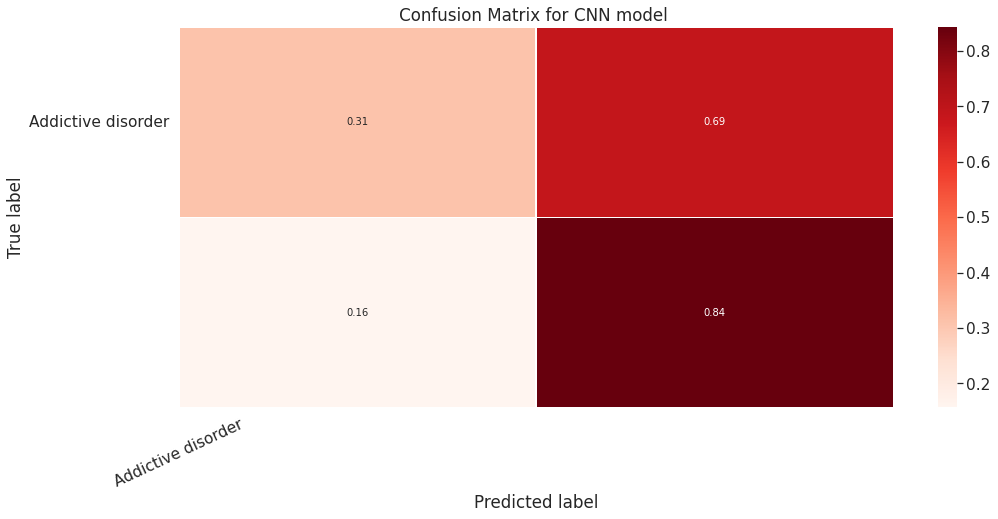

In [97]:
matrix = confusion_matrix(y_test, ypred)
matrix = matrix.astype('float') / matrix.sum(axis=1)[:, np.newaxis]

# Build the plot
plt.figure(figsize=(16,7))
sns.set(font_scale=1.4)
sns.heatmap(matrix, annot=True, annot_kws={'size':10},
            cmap=plt.cm.Reds, linewidths=0.2)

# Add labels to the plot
class_names = ['Addictive disorder']
tick_marks = np.arange(len(class_names))
tick_marks2 = tick_marks + 0.5
plt.xticks(tick_marks, class_names, rotation=25)
plt.yticks(tick_marks2, class_names, rotation=0)
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.title('Confusion Matrix for CNN model ')
plt.show()

In [17]:
def true_positive(y_true, y_pred):
    
    tp = 0
    
    for yt, yp in zip(y_true, y_pred):
        
        if yt == 1 and yp == 1:
            tp += 1
    
    return tp

def true_negative(y_true, y_pred):
    
    tn = 0
    
    for yt, yp in zip(y_true, y_pred):
        
        if yt == 0 and yp == 0:
            tn += 1
            
    return tn

def false_positive(y_true, y_pred):
    
    fp = 0
    
    for yt, yp in zip(y_true, y_pred):
        
        if yt == 0 and yp == 1:
            fp += 1
            
    return fp

def false_negative(y_true, y_pred):
    
    fn = 0
    
    for yt, yp in zip(y_true, y_pred):
        
        if yt == 1 and yp == 0:
            fn += 1
            
    return fn

In [18]:
def macro_precision(y_true, y_pred):

    # find the number of classes
    num_classes = len(np.unique(y_true))

    # initialize precision to 0
    precision = 0
    
    # loop over all classes
    for class_ in list(y_true.unique()):
        
        # all classes except current are considered negative
        temp_true = [1 if p == class_ else 0 for p in y_true]
        temp_pred = [1 if p == class_ else 0 for p in y_pred]
        
        
        # compute true positive for current class
        tp = true_positive(temp_true, temp_pred)
        
        # compute false positive for current class
        fp = false_positive(temp_true, temp_pred)
        
        
        # compute precision for current class
        temp_precision = tp / (tp + fp + 1e-6)
        # keep adding precision for all classes
        precision += temp_precision
        
    # calculate and return average precision over all classes
    precision /= num_classes
    
    return precision

In [19]:
print(f"Macro-averaged Precision score : {macro_precision(y_test, ypred) }")

Macro-averaged Precision score : 0.5758928388327641


In [20]:
macro_averaged_precision = metrics.precision_score(y_test, ypred, average = 'macro')

In [21]:
print(f"Macro-Averaged Precision score using sklearn library : {macro_averaged_precision}")

Macro-Averaged Precision score using sklearn library : 0.5758928571428572


In [22]:
def micro_precision(y_true, y_pred):


    # find the number of classes 
    num_classes = len(np.unique(y_true))
    
    # initialize tp and fp to 0
    tp = 0
    fp = 0
    
    # loop over all classes
    for class_ in y_true.unique():
        
        # all classes except current are considered negative
        temp_true = [1 if p == class_ else 0 for p in y_true]
        temp_pred = [1 if p == class_ else 0 for p in y_pred]
        
        # calculate true positive for current class
        # and update overall tp
        tp += true_positive(temp_true, temp_pred)
        
        # calculate false positive for current class
        # and update overall tp
        fp += false_positive(temp_true, temp_pred)
        
    # calculate and return overall precision
    precision = tp / (tp + fp)
    return precision

In [23]:
print(f"Micro-averaged Precision score : {micro_precision(y_test, ypred)}")

Micro-averaged Precision score : 0.6666666666666666


In [24]:
micro_averaged_precision = metrics.precision_score(y_test, ypred, average = 'micro')
print(f"Micro-Averaged Precision score using sklearn library : {micro_averaged_precision}")

Micro-Averaged Precision score using sklearn library : 0.6666666666666666


In [25]:
def macro_recall(y_true, y_pred):

    # find the number of classes
    num_classes = len(np.unique(y_true))

    # initialize recall to 0
    recall = 0
    
    # loop over all classes
    for class_ in list(y_true.unique()):
        
        # all classes except current are considered negative
        temp_true = [1 if p == class_ else 0 for p in y_true]
        temp_pred = [1 if p == class_ else 0 for p in y_pred]
        
        
        # compute true positive for current class
        tp = true_positive(temp_true, temp_pred)
        
        # compute false negative for current class
        fn = false_negative(temp_true, temp_pred)
        
        
        # compute recall for current class
        temp_recall = tp / (tp + fn + 1e-6)
        
        # keep adding recall for all classes
        recall += temp_recall
        
    # calculate and return average recall over all classes
    recall /= num_classes
    
    return recall

In [26]:
print(f"Macro-averaged recall score : {macro_recall(y_test, ypred)}")

Macro-averaged recall score : 0.5503771442968346


In [27]:
macro_averaged_recall = metrics.recall_score(y_test, ypred, average = 'macro')
print(f"Macro-averaged recall score using sklearn : {macro_averaged_recall}")

Macro-averaged recall score using sklearn : 0.5503771551724138


In [28]:
def micro_recall(y_true, y_pred):


    # find the number of classes 
    num_classes = len(np.unique(y_true))
    
    # initialize tp and fp to 0
    tp = 0
    fn = 0
    
    # loop over all classes
    for class_ in y_true.unique():
        
        # all classes except current are considered negative
        temp_true = [1 if p == class_ else 0 for p in y_true]
        temp_pred = [1 if p == class_ else 0 for p in y_pred]
        
        # calculate true positive for current class
        # and update overall tp
        tp += true_positive(temp_true, temp_pred)
        
        # calculate false negative for current class
        # and update overall tp
        fn += false_negative(temp_true, temp_pred)
        
    # calculate and return overall recall
    recall = tp / (tp + fn)
    return recall

In [29]:
print(f"Micro-averaged recall score : {micro_recall(y_test, ypred)}")

Micro-averaged recall score : 0.6666666666666666


In [30]:
micro_averaged_recall = metrics.recall_score(y_test, ypred, average = 'micro')
print(f"Micro-Averaged recall score using sklearn library : {micro_averaged_recall}")

Micro-Averaged recall score using sklearn library : 0.6666666666666666


In [31]:
macro_averaged_f1 = metrics.f1_score(y_test, ypred, average = 'macro')
print(f"Macro-Averaged F1 score using sklearn library : {macro_averaged_f1}")

Macro-Averaged F1 score using sklearn library : 0.5456264775413711


In [32]:
micro_averaged_f1 = metrics.f1_score(y_test, ypred, average = 'micro')
print(f"Micro-Averaged F1 score using sklearn library : {micro_averaged_f1}")

Micro-Averaged F1 score using sklearn library : 0.6666666666666666


In [33]:
from sklearn.metrics import roc_auc_score

def roc_auc_score_multiclass(actual_class, pred_class, average = "macro"):
    
    #creating a set of all the unique classes using the actual class list
    unique_class = set(actual_class)
    roc_auc_dict = {}
    for per_class in unique_class:
        
        #creating a list of all the classes except the current class 
        other_class = [x for x in unique_class if x != per_class]

        #marking the current class as 1 and all other classes as 0
        new_actual_class = [0 if x in other_class else 1 for x in actual_class]
        new_pred_class = [0 if x in other_class else 1 for x in pred_class]

        #using the sklearn metrics method to calculate the roc_auc_score
        roc_auc = roc_auc_score(new_actual_class, new_pred_class, average = average)
        roc_auc_dict[per_class] = roc_auc

    return roc_auc_dict

In [34]:
roc_auc_dict = roc_auc_score_multiclass(y_test, ypred)
roc_auc_dict

{0.0: 0.5503771551724138, 1.0: 0.5503771551724138}

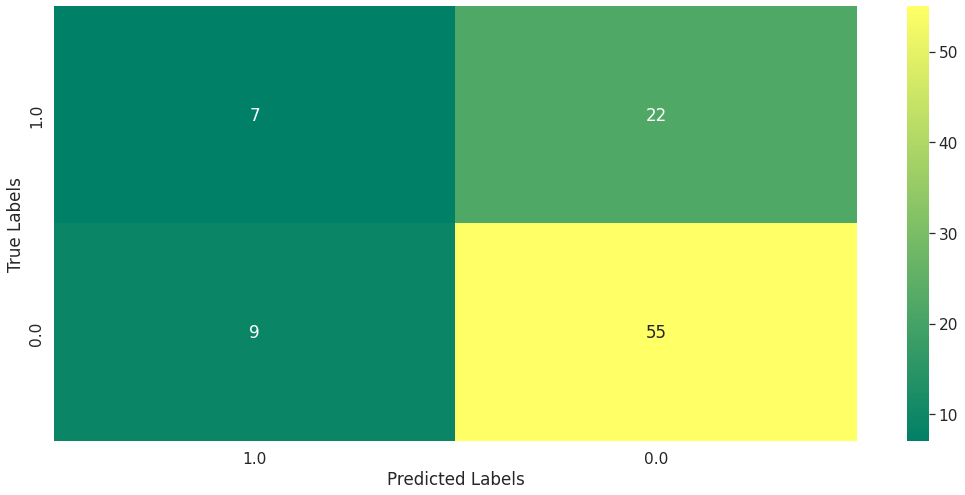

In [35]:
plt.figure(figsize = (18,8))
sns.heatmap(metrics.confusion_matrix(y_test, ypred), annot = True, xticklabels = y_test.unique(), yticklabels = y_test.unique(), cmap = 'summer')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()